# Esercitazione lab8

- Confronto dei metodi:
  + K-means
  + K-medoids
  + Agglomerative clustering
  + Clustering spettrale
  + Partitioning
  + DBSCAN
  + Mixture models

- utilizzate come Database:
    + `digits`
    + `make_moons`
    
- Dovete utilizzare una CV Stratified per la migliore scelta di iperparametri, e la K migliore in base alla distorsione (inertia) e silhouette score.
- Model selection con BIC score e Gaussian Mixture Models

- esperimentare con x-means

# Pre-processing

## Load database

In [2]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [3]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

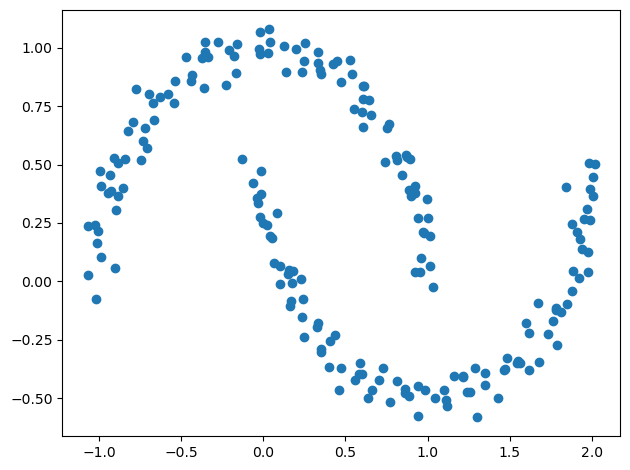

In [4]:
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
plt.show()

# CV per clustering

La funzione `generate_stratified_bins(X, n_bins)` applica KMeans ai dati X per assegnare ogni punto a un cluster. I cluster così ottenuti vengono usati come etichette fittizie per fare stratificazione nella validazione incrociata.

`clustering_cv(...)` effettua una validazione incrociata personalizzata per modelli di clustering.

    X: dataset (solo features, senza etichette).

    model_class: classe del modello (es. KMeans).

    param_grid: dizionario di parametri da testare 
    
    n_folds, n_repeats: k-fold CV ripetuta.

    stratify_bins: quanti cluster creare per la pseudo-stratificazione.

    sample_frac: frazione del training set da usare per il fit del modello (per variabilità).

 
ParameterGrid(param_grid): Itera su tutte le combinazioni di parametri.
- rskf.split(X, stratify_labels):
Usa i cluster ottenuti da KMeans come etichette surrogate per fare una validazione stratificata.

- Per ogni split:

    Campiona il 30% dei dati di training (resample).

    Clona e addestra il modello con quei dati.

    Estrae le etichette prodotte (model.labels_ o model.predict(...)).

    Calcola:

        Silhouette score → misura della coesione/separazione dei cluster.

        Inertia → somma delle distanze intra-cluster (valida solo per KMeans).

        Numero di cluster effettivo.

Ritorna un DataFrame con i risultati per ciascun fold e ciascun set di parametri.

Ritorna anche i migliori parametri, cioè quelli con il silhouette score medio più alto.

In [5]:
from sklearn.base import clone
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid, RepeatedStratifiedKFold
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# pseudo-stratified labels con KMeans, etichette fittize per strattificazione
def generate_stratified_bins(X, n_bins=3):
    km = KMeans(n_clusters=n_bins, random_state=42, n_init= 10)
    return km.fit_predict(X)


def clustering_cv(X, model_class, param_grid, n_folds=5, n_repeats=5,
                  stratify_bins=5, 
                  sample_frac=0.3, 
                  random_state=42):
    results = []
    X = StandardScaler().fit_transform(X)

    stratify_labels = generate_stratified_bins(X, n_bins=stratify_bins)
    rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=random_state)

    for params in ParameterGrid(param_grid):
        for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X, stratify_labels)):
            X_train = X[train_idx]
            X_train_sampled = resample(X_train, replace=False, n_samples=int(sample_frac * len(X_train)),
                                       random_state=random_state)

            model = clone(model_class(**params))
            model.fit(X_train_sampled)

            if hasattr(model, "labels_"):
                labels = model.labels_
                inertia = model.inertia_ if hasattr(model, "inertia_") else np.nan
            elif hasattr(model, "predict"):
                labels = model.predict(X_train_sampled)
                inertia = np.nan
            else:
                continue

            if len(set(labels)) > 1:
                sil = silhouette_score(X_train_sampled, labels)
            else:
                sil = np.nan

            results.append({
                "params": params,
                "fold": fold_idx,
                "silhouette": sil,
                "inertia": inertia,
                "n_clusters": len(set(labels))
            })

    df = pd.DataFrame(results)
    mean_scores = df.groupby(df['params'].apply(lambda x: tuple(sorted(x.items())))).mean(numeric_only=True)
    best_idx = mean_scores["silhouette"].idxmax()
    best_params = dict(best_idx)

    return best_params, df

## CV per spectral clust

Validazione incrociata non supervisionata per modelli di clustering usando Spectral Clustering e la metrica Normalized Mutual Information (NMI.

`generate_stratified_bins(X, n_bins` Applica Spectral Clustering per creare etichette surrogate. Queste etichette sono usate per la stratificazione nella CV, come se fossero target.

`spectral_cv` Scala i dati con StandardScaler. Genera etichette surrogate da Spectral Clustering. Usa RepeatedStratifiedKFold per suddividere i dati in fold stratificati.

Per ogni combinazione di parametri:

    Divide i dati in fold.

    Campiona una parte (sample_frac) del training set.

    Clona e allena il modello sul sottoinsieme.

    Estrae le etichette ottenute.

    Se ci sono almeno 2 cluster distinti, calcola l’NMI confrontando:

        Le etichette ottenute dal modello.

        Le etichette ottenute da un altro Spectral Clustering indipendente.

In [6]:
from sklearn.base import clone
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import ParameterGrid, RepeatedStratifiedKFold
from sklearn.cluster import SpectralClustering
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

def generate_stratified_bins(X, n_bins=2):
    spectral_model = SpectralClustering(n_clusters=n_bins, 
                                        affinity='nearest_neighbors', 
                                        random_state=42)
    return spectral_model.fit_predict(X)

def spectral_cv(X, model_class, param_grid, n_folds=5, n_repeats=2, 
                stratify_bins=2, sample_frac=0.2, random_state=42):
    results = []
    X = StandardScaler().fit_transform(X)

    stratify_labels = generate_stratified_bins(X, n_bins=stratify_bins)
    rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=random_state)

    for params in ParameterGrid(param_grid):
        for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X, stratify_labels)):
            X_train = X[train_idx]
            X_train_sampled = resample(X_train, replace=False, n_samples=int(sample_frac * len(X_train)),
                                       random_state=random_state)

            model = clone(model_class(**params))
            model.fit(X_train_sampled)

            if hasattr(model, "labels_"):
                labels = model.labels_
            elif hasattr(model, "predict"):
                labels = model.predict(X_train_sampled)
            else:
                continue

            if len(set(labels)) > 1:
                spectral_labels = SpectralClustering(n_clusters=len(set(labels)), 
                                                     affinity='nearest_neighbors', 
                                                     random_state=random_state).fit_predict(X_train_sampled)
                nmi = normalized_mutual_info_score(spectral_labels, labels)
            else:
                nmi = np.nan

            results.append({
                "params": params,
                "fold": fold_idx,
                "nmi": nmi,
                "n_clusters": len(set(labels))
            })

    df = pd.DataFrame(results)
    mean_scores = df.groupby(df['params'].apply(lambda x: tuple(sorted(x.items())))).mean(numeric_only=True)

    best_idx = mean_scores["nmi"].idxmax()
    best_params = dict(best_idx)

    return best_params, df

# Clustering techniques

## Partition techniques

### K-means

In [7]:
import pprint
from sklearn.cluster import KMeans

param_grid = {
    'n_clusters': [2, 3],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20]
}

best_params, results_df = clustering_cv(X, KMeans, param_grid)
display("Best parameters:", best_params)

/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


'Best parameters:'

{'init': 'k-means++', 'n_clusters': 2, 'n_init': 10}

#### Visualizzazioni

Retraining con i parametri migliori.

'Silhouette Score: 0.4922'

'Distortion (Inertia): 79.6623'

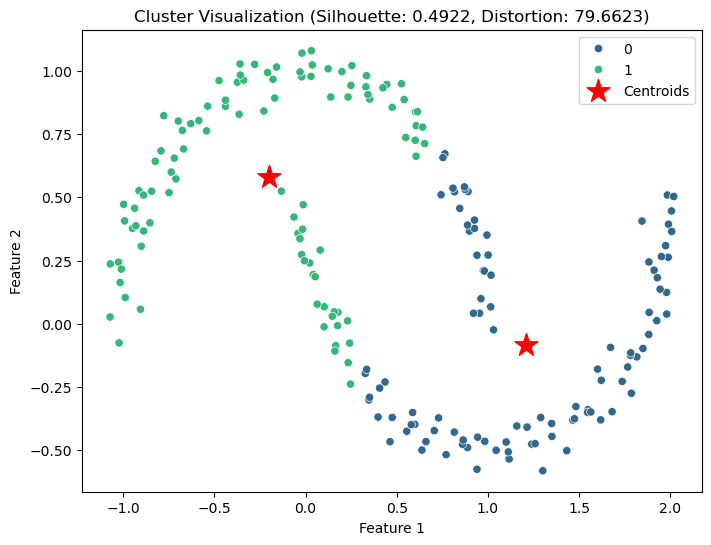

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

model = KMeans(
    n_clusters=best_params['n_clusters'],
    init=best_params['init'],
    n_init= best_params['n_init']
).fit(X)

labels = model.predict(X)

sil_score = silhouette_score(X, labels)

distortion = model.inertia_

display(f"Silhouette Score: {sil_score:.4f}")
display(f"Distortion (Inertia): {distortion:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='viridis', legend='full')
plt.title(f'Cluster Visualization (Silhouette: {sil_score:.4f}, Distortion: {distortion:.4f})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

centroids = model.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='*', label='Centroids')
plt.legend()
plt.show()

Andamento delle metriche di `sil_score` e `inertia` per capire se ci sono andamenti diversi.

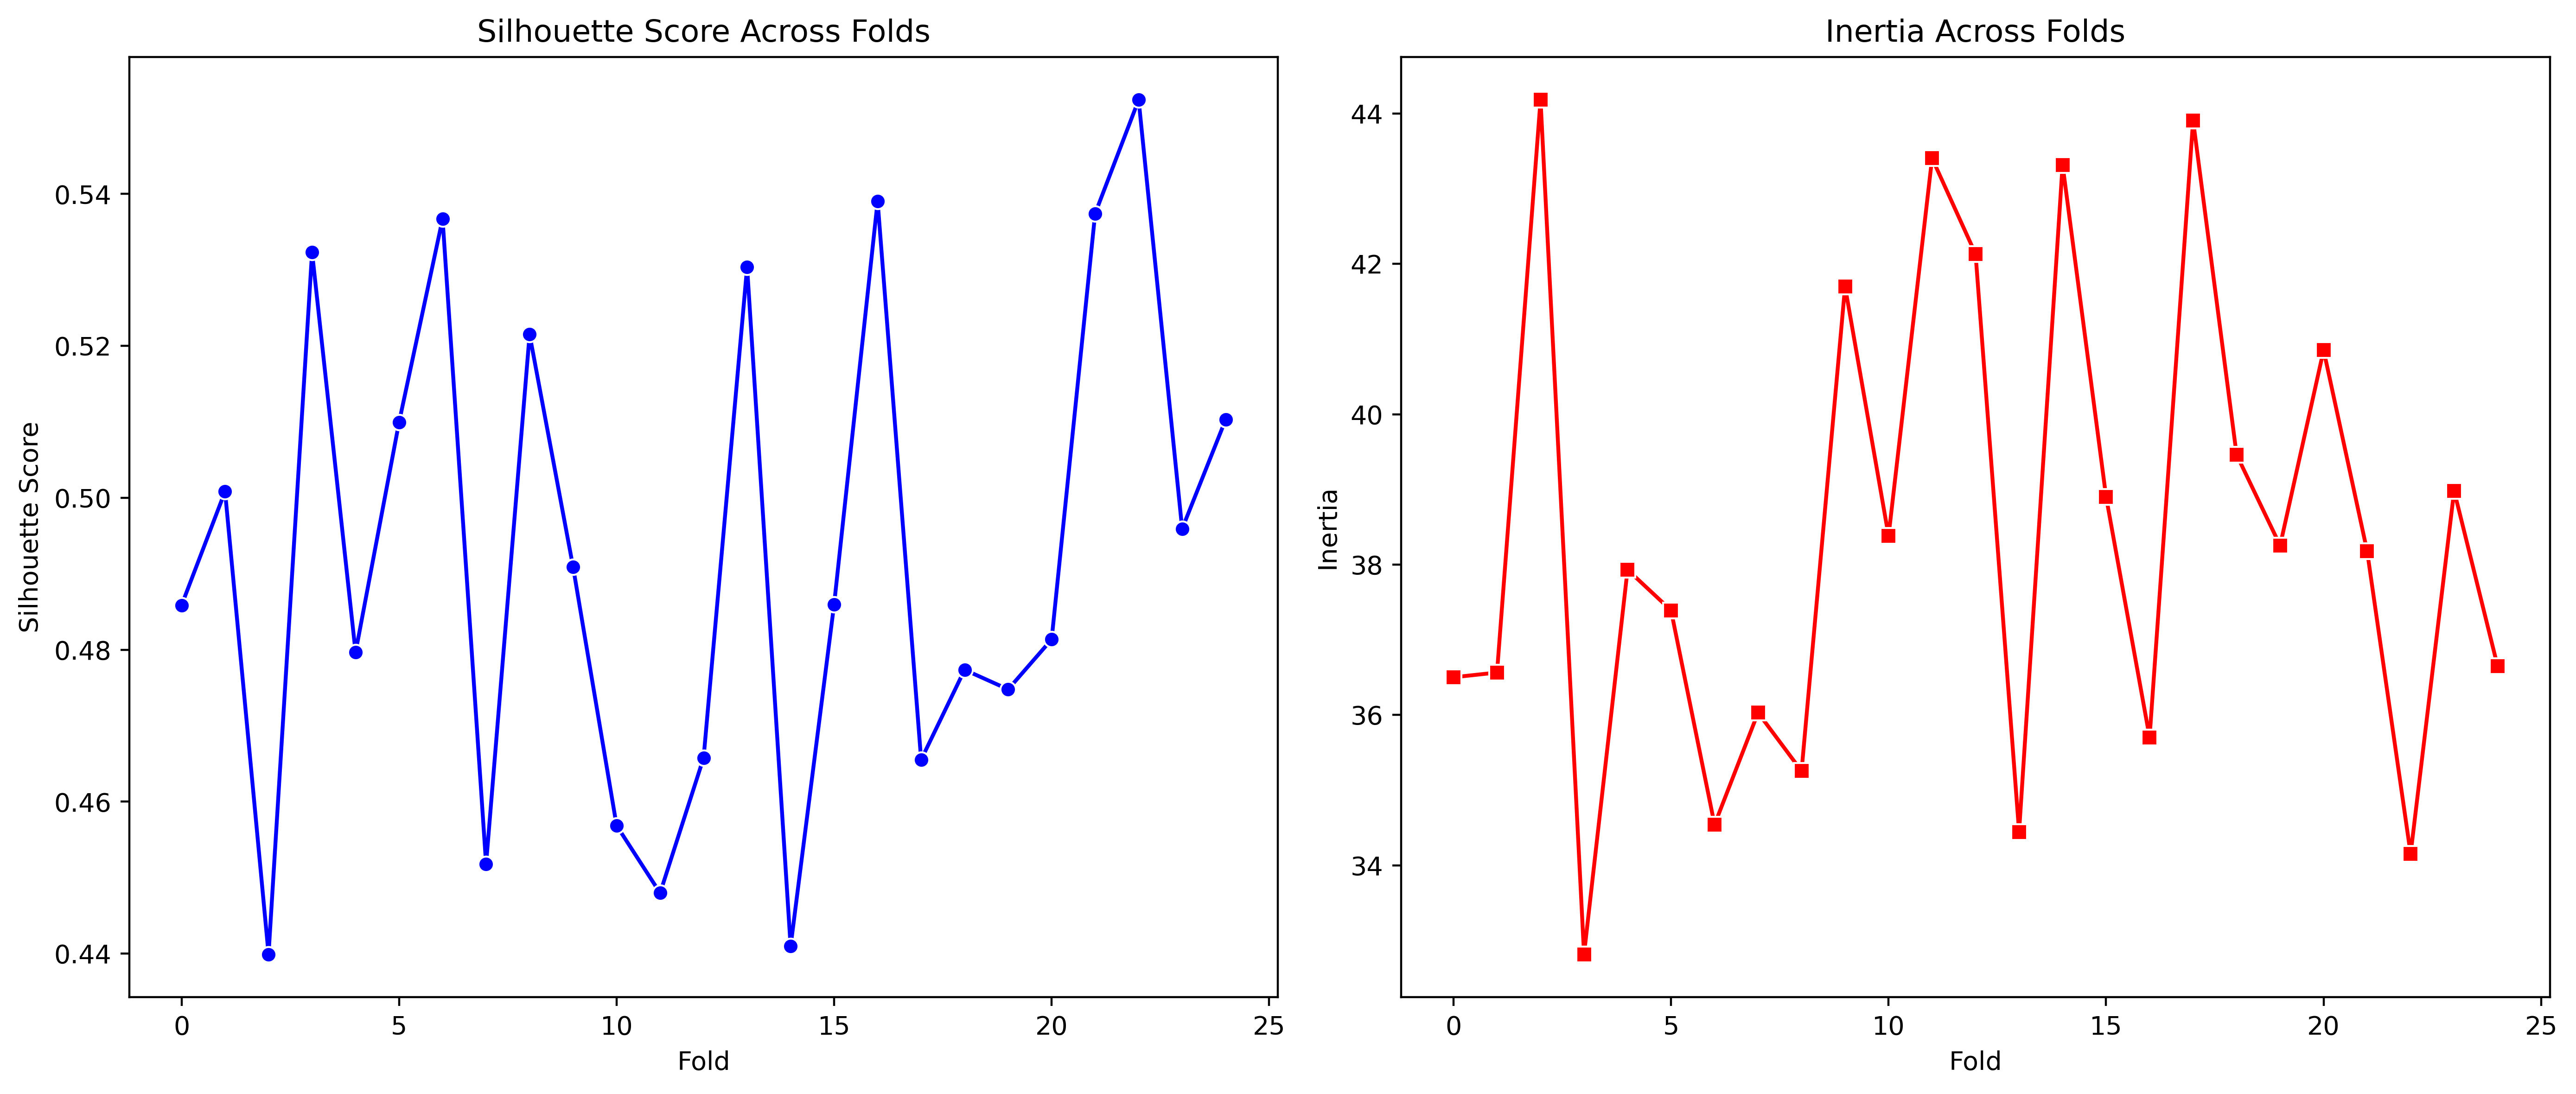

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

best_combination_df = results_df[
    (results_df['params'].apply(lambda x: x['init'] == 'k-means++')) &
    (results_df['n_clusters'] == 2) &
    (results_df['params'].apply(lambda x: x['n_init'] == 10))
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi = 400)

sns.lineplot(data=best_combination_df, x='fold', y='silhouette', ax=ax1, marker='o', color='b')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score Across Folds')

sns.lineplot(data=best_combination_df, x='fold', y='inertia', ax=ax2, marker='s', color='r')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Inertia')
ax2.set_title('Inertia Across Folds')

fig.tight_layout()

plt.show()

Andamento di silhouette score per vari fold.

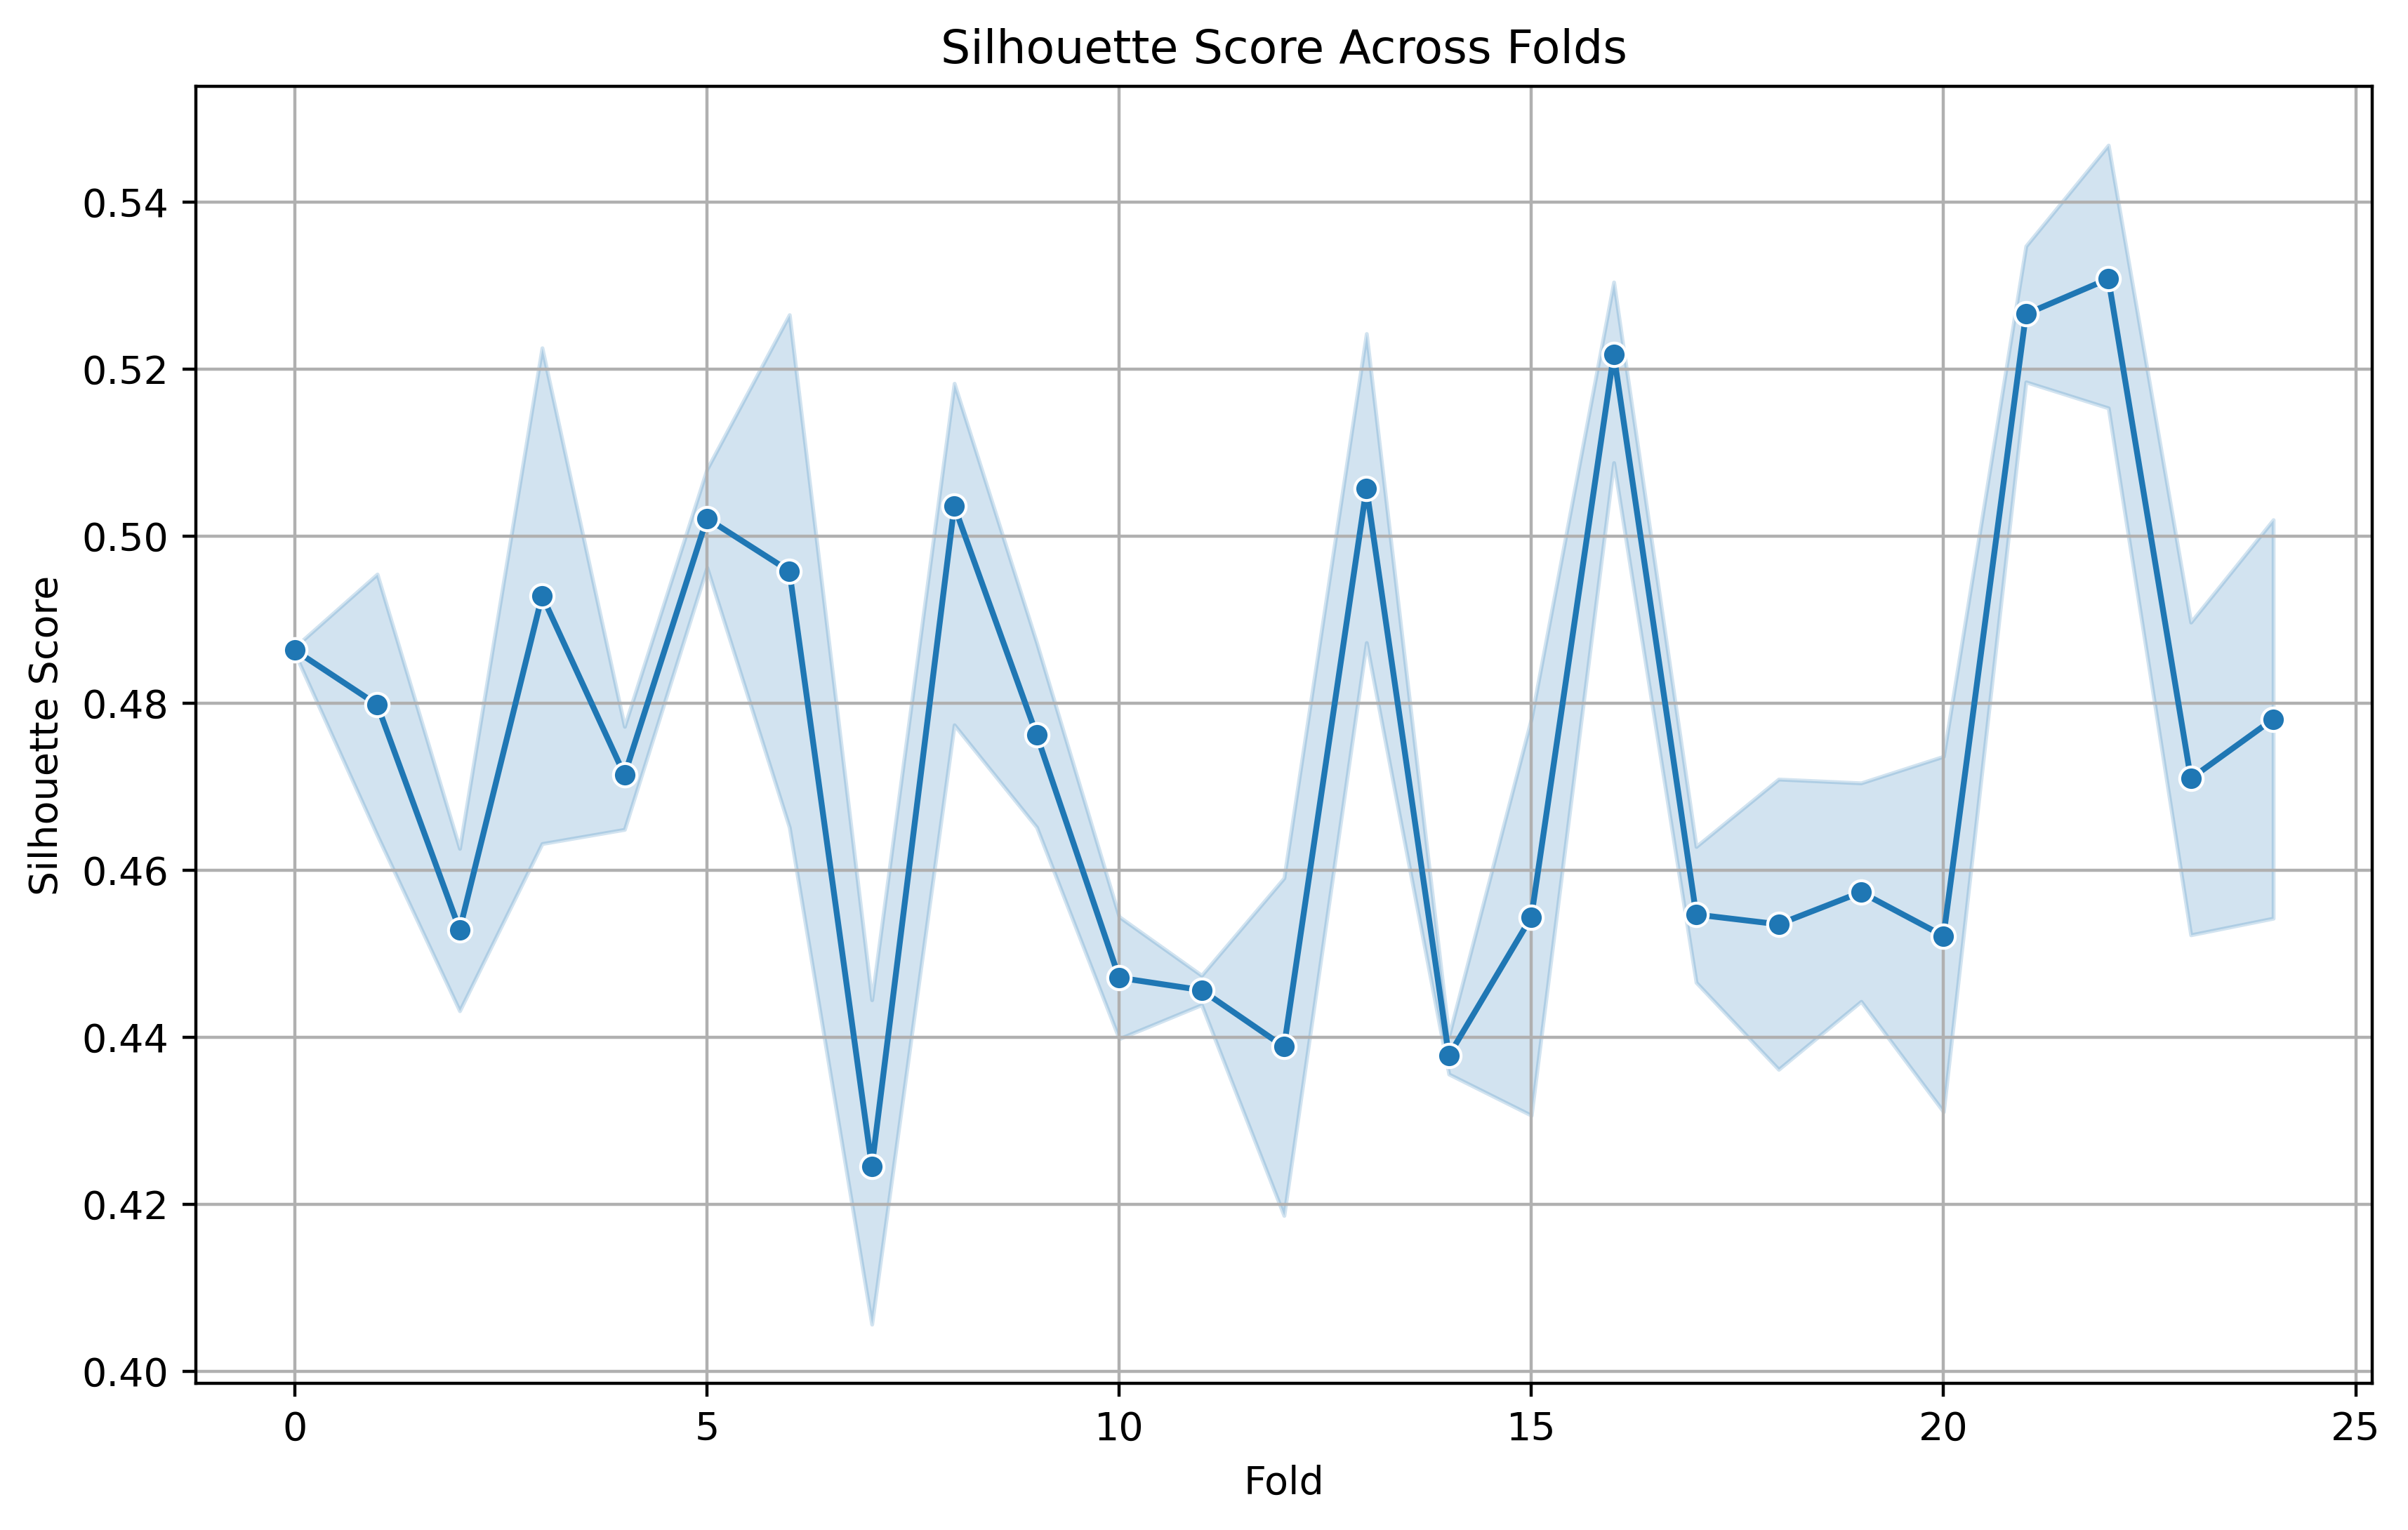

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6), dpi= 400)
sns.lineplot(data=results_df, x='fold', y='silhouette', marker='o')

plt.title('Silhouette Score Across Folds')
plt.xlabel('Fold')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### K-medoids

In [11]:
from sklearn_extra.cluster import KMedoids

param_grid = {
    'n_clusters': [2, 3],
    'metric': ['euclidean', 'manhattan'],
    'method': ['alternate', 'pam'],
    'init': ['heuristic', 'random'],
    'max_iter': [300, 500],
}

best_params, results_df = clustering_cv(X, KMedoids, param_grid)
print("Best parameters:", best_params)

/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/hom

Best parameters: {'init': 'random', 'max_iter': 300, 'method': 'pam', 'metric': 'euclidean', 'n_clusters': 2}


/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [12]:
max_silhouette_row = results_df.loc[results_df['silhouette'].idxmax()]
display("Row with the maximum silhouette score:", max_silhouette_row)

'Row with the maximum silhouette score:'

params        {'init': 'heuristic', 'max_iter': 300, 'method...
fold                                                         22
silhouette                                              0.54084
inertia                                               39.343396
n_clusters                                                    2
Name: 22, dtype: object

### Spectral clustering 

In [13]:
from sklearn.cluster import SpectralClustering

param_grid = {
    'n_clusters': [2, 3],
    'affinity': ['rbf','nearest_neighbors'],
    'assign_labels': ['kmeans', 'discretize'],
    'gamma': [0.5, 0.7, 0.8],
    'eigen_solver': ['arpack', 'amg'],
    'eigen_tol': [1e-3, 1e-4, 1e-5],
}

best_params, results_df = spectral_cv(X, SpectralClustering, param_grid)
print("Best parameters:", best_params)

/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Best parameters: {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'eigen_solver': 'amg', 'eigen_tol': 1e-05, 'gamma': 0.5, 'n_clusters': 2}


In [14]:
best_params

{'affinity': 'nearest_neighbors',
 'assign_labels': 'kmeans',
 'eigen_solver': 'amg',
 'eigen_tol': 1e-05,
 'gamma': 0.5,
 'n_clusters': 2}

#### Retrain

NMI Score: 1.0000


/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


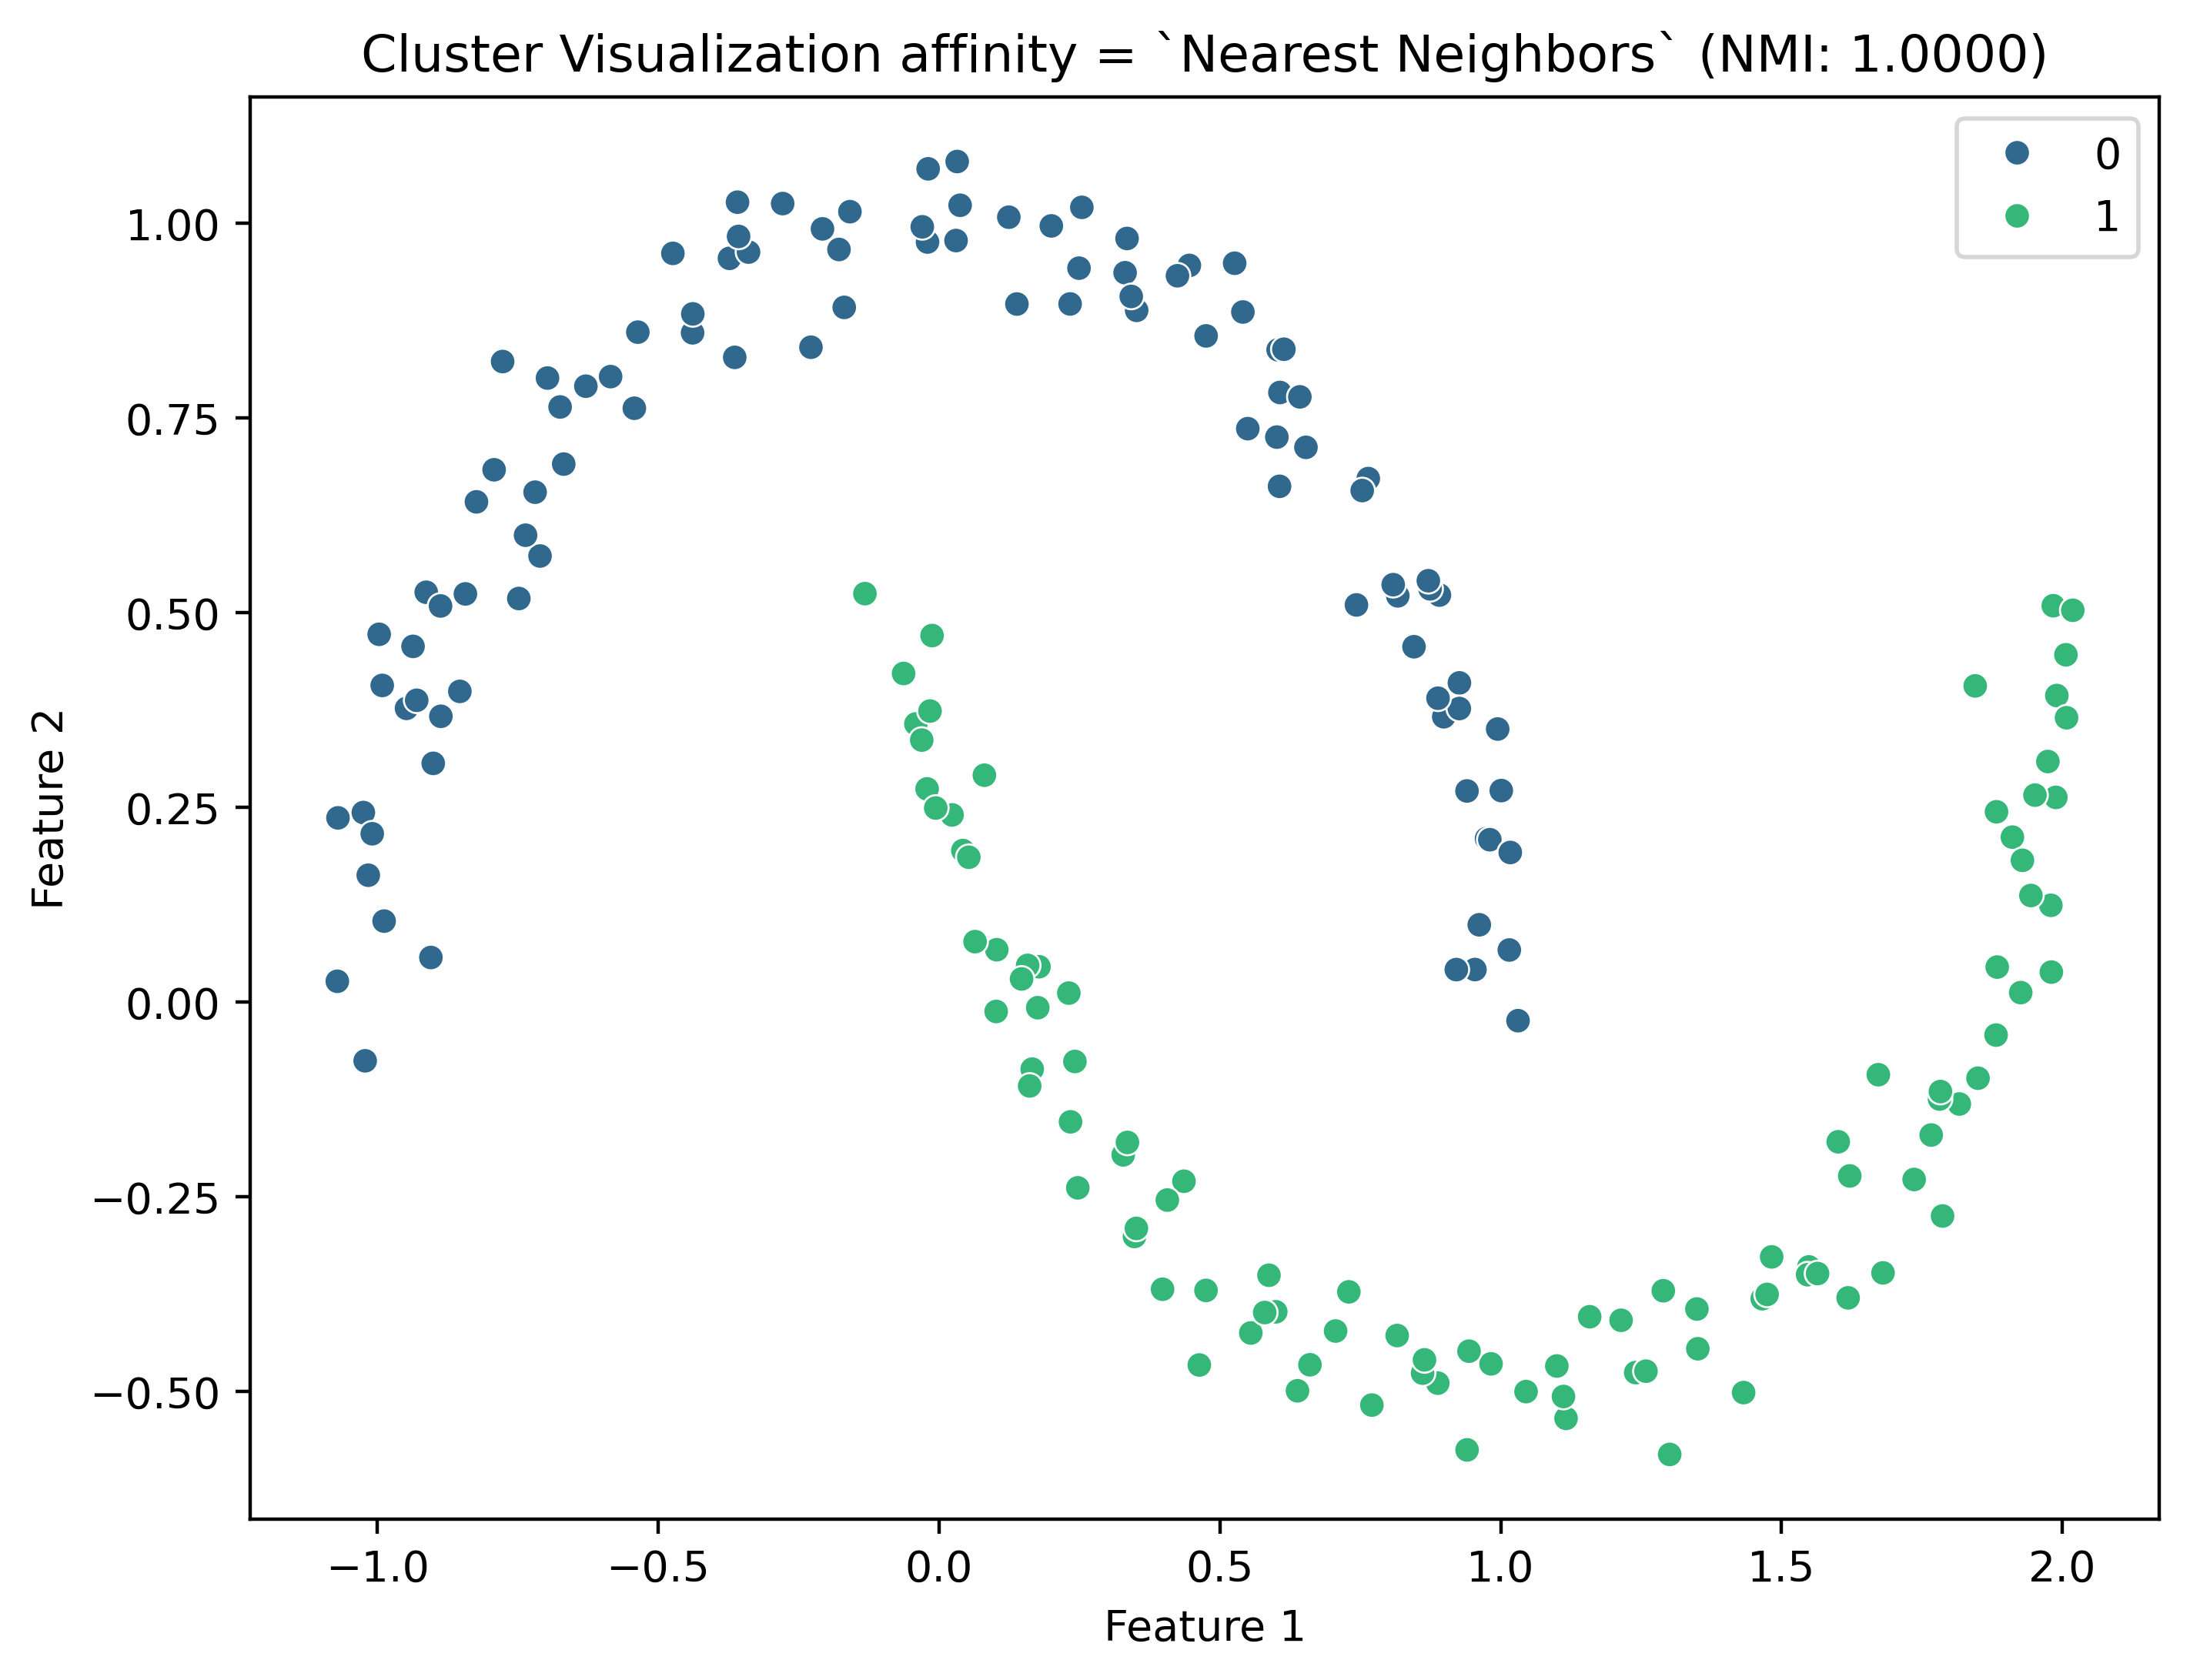

In [15]:
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering

model = SpectralClustering(
    n_clusters=best_params['n_clusters'], 
    affinity= best_params['affinity'],  
    assign_labels=best_params['assign_labels'],
    gamma=best_params['gamma'],
    eigen_solver=best_params['eigen_solver'],
    eigen_tol=best_params['eigen_tol']
).fit(X)

labels = model.labels_

spectral_labels = SpectralClustering(n_clusters=2, 
                                     affinity='nearest_neighbors', 
                                     random_state=42).fit_predict(X)

nmi_score = normalized_mutual_info_score(spectral_labels, labels)

print(f"NMI Score: {nmi_score:.4f}")

plt.figure(figsize=(8, 6), dpi=400)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='viridis', legend='full')
plt.title(f'Cluster Visualization affinity = `Nearest Neighbors` (NMI: {nmi_score:.4f})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
#plt.savefig('nearest_neighbors_spect_clust_moons.png')

## Hierarchical clustering

### Agglomerative clustering

In [16]:
from sklearn.cluster import AgglomerativeClustering

param_grid = {
    'n_clusters': [2, 3, 4],
    'metric': ['euclidean', 'manhattan'],  
    'linkage': ['complete', 'average', 'single']
}

best_params, results_df = clustering_cv(X, AgglomerativeClustering, param_grid)
print("Best parameters:", best_params)

/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Best parameters: {'linkage': 'complete', 'metric': 'euclidean', 'n_clusters': 2}


#### Agg_clust `ward`

`ward` funziona solo con la distanza di `euclidean`

In [17]:
from sklearn.cluster import AgglomerativeClustering

param_grid = {
    'n_clusters': [2, 3, 4],
    'metric': ['euclidean'],  
    'linkage': ['ward']
}

best_params_2, results_df_2 = clustering_cv(X, AgglomerativeClustering, param_grid)
print("Best parameters:", best_params)

Best parameters: {'linkage': 'complete', 'metric': 'euclidean', 'n_clusters': 2}


/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Retraining per visualizzare i clusters.

Silhouette Score: 0.4760


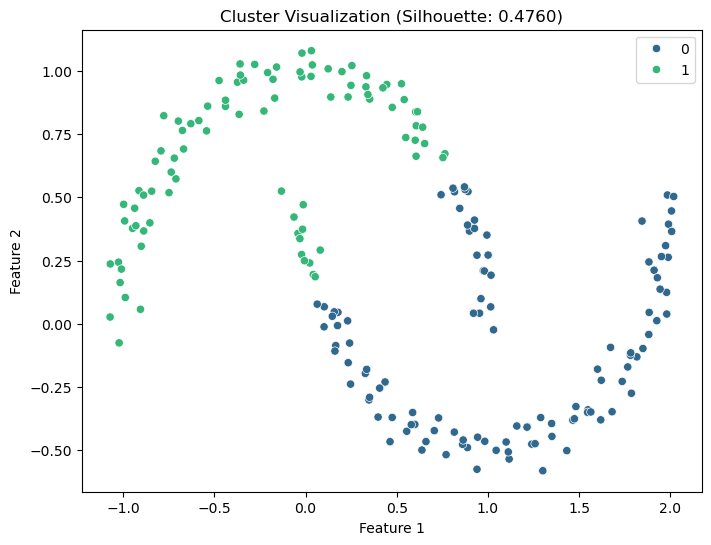

In [18]:
import seaborn as sns

model = AgglomerativeClustering(
    n_clusters=best_params['n_clusters'],
    metric=best_params['metric'],
    linkage=best_params['linkage']
).fit(X)

labels = model.labels_

sil_score = silhouette_score(X, labels)

print(f"Silhouette Score: {sil_score:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='viridis', legend='full')
plt.title(f'Cluster Visualization (Silhouette: {sil_score:.4f})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### DBSCAN

In [19]:
from sklearn.cluster import DBSCAN

param_grid = {
    'eps': [0.3, 0.5, 0.7],        
    'min_samples': [3, 5, 10],     
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

best_params, results_df = clustering_cv(X, DBSCAN, param_grid)
print("Best parameters:", best_params)

/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Best parameters: {'algorithm': 'auto', 'eps': 0.5, 'metric': 'manhattan', 'min_samples': 3}


## Modelli probabilistici

### Gaussian Mixture Models

In [20]:
from sklearn.mixture import GaussianMixture

param_grid = {
    'n_components': [2, 3, 4],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'], 
    'max_iter': [100, 200, 300],  
    'init_params': ['kmeans', 'random'], 
    #'tol': [1e-3, 1e-4]
}

best_params, results_df = clustering_cv(X, GaussianMixture, param_grid)
print("Best parameters:", best_params)

/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Best parameters: {'covariance_type': 'tied', 'init_params': 'kmeans', 'max_iter': 200, 'n_components': 2}


### BIC + GMM

#### BIC function

Questa funzione genera tutte le combinazioni possibili di parametri (product).

Per ogni combinazione:

    Crea un modello GMM con quei parametri.

    Lo allena su tutto il dataset (nessuna vera divisione in fold).

    Calcola il BIC sul dataset intero più volte (numero di fold, ma senza differenziare i dati).

    Fa la media dei BIC ottenuti.

Infine, restituisce la combinazione con il BIC più basso.

In [21]:
from itertools import product

def clustering_bic(X, model_class, param_grid, n_folds=5, random_state=None):
    results = []

    for params in (dict(zip(param_grid, x)) for x in product(*param_grid.values())):
        model = model_class(**params)
        bic_scores = []

        for fold in range(n_folds):
            model.fit(X)
            bic = model.bic(X)
            bic_scores.append(bic)

        avg_bic = np.mean(bic_scores)
        results.append((params, avg_bic))

    best_params = min(results, key=lambda x: x[1])[0]
    return best_params, pd.DataFrame(results, columns=['Parameters', 'BIC'])

#### Gaussian Mixture Models

In [22]:
from sklearn.mixture import GaussianMixture
import pandas as pd
import numpy as np

param_grid = {
    'n_components': [2, 3, 4],  
    'covariance_type': ['full', 'tied', 'diag', 'spherical'], 
    'max_iter': [100, 200], 
    'init_params': ['kmeans', 'random'],  
    #'tol': [1e-3, 1e-4],  # Tolerance for convergence
}

In [24]:
best_params, results_df = clustering_bic(X, GaussianMixture, param_grid)
display("Best parameters based on BIC:", best_params)

'Best parameters based on BIC:'

{'n_components': 4,
 'covariance_type': 'full',
 'max_iter': 100,
 'init_params': 'kmeans'}